In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        a2 = F.softmax(l2, dim=1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return a2

In [2]:
import numpy as np

class Agent() :
    def __init__(self, state_dim, hidden_dim, action_dim, gamma) :
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim)
        # optimizer, lr,
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=0.001)
        
        self.observation_list = []
        self.actions_list = []
        self.reward_list = []
        self.gamma = gamma
        
    def take_action(self, state, env) :
        state = torch.tensor(state, dtype=torch.float64).unsqueeze(0)
        actions = self.policy_net(state).squeeze()
        action = env.action_space.sample(probability=actions.detach().numpy())
        #print(actions, action)
        return action

    def update(self, observation_list, actions_list, reward_list) :  
        observation_list.reverse()
        actions_list.reverse()
        reward_list.reverse()
        
        step_num = len(observation_list)
        G = 0

        self.optimizer.zero_grad()
        total_target = 0
        for i in range(0, step_num) :
            observation = observation_list[i]
            reward = reward_list[i]
                
            #G += reward + self.gamma * G 
            G = reward + self.gamma * G

            state = torch.tensor(observation, dtype=torch.float64).unsqueeze(0)
            actions = self.policy_net(state).squeeze()
                
            target = - actions[actions_list[i]].log() * G
            #print(target)
            #target.backward()
            total_target += target
        total_target.backward()
        self.optimizer.step()

In [3]:
import os
os.environ['SDL_AUDIODRIVER'] = 'dummy'
os.environ['XDG_RUNTIME_DIR'] = '/home/youngsure/Code/tmp/'

import gymnasium as gym

# env init
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=0)
#print(observation)

# agent init
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
gamma = 0.98
agent = Agent(state_dim, hidden_dim, action_dim, gamma)

return_list = []

for i in range(1000) :
    observation, info = env.reset()#(seed=0)
    episode_over = False
    total_reward = 0

    observation_list = []
    actions_list = []
    reward_list = []
    while not episode_over:
        action = agent.take_action(observation, env)
        next_observation, reward, terminated, truncated, info = env.step(action)

        observation_list.append(observation)
        actions_list.append(action)
        reward_list.append(reward)
    
        total_reward += reward

        observation = next_observation
        episode_over = terminated or truncated
    agent.update(observation_list, actions_list, reward_list)

    return_list.append(total_reward)

    #print(f"Episode finished! Total reward: {total_reward}")
env.close()

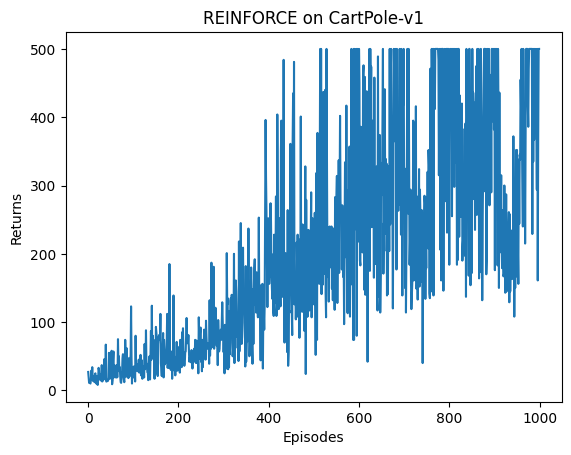

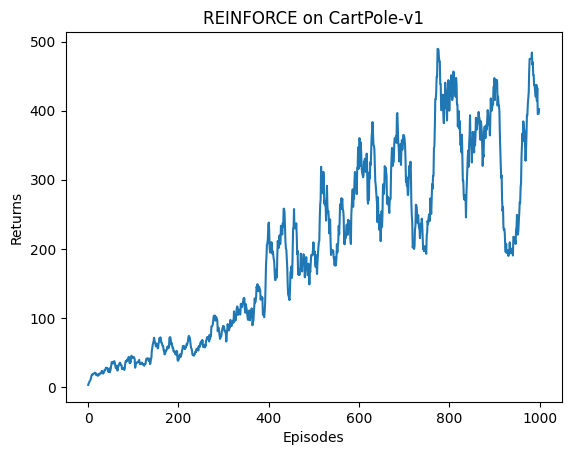

In [4]:
import matplotlib.pyplot as plt
env_name = "CartPole-v1"

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(return_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()